<a href="https://colab.research.google.com/github/massinoLight/HandwrittenSignatureForgeryDetectionUsingCNN/blob/master/Handwritten_Signature_Forgery_Detection_Using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importer les data sets presentes sur github au format zip**

In [2]:
#Import une partie de la dataset du fichier zip qui est sur le github
import pathlib
import os
import cv2
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import datetime
from tensorflow import keras
from tensorflow.keras.models import Model
import tensorflow as tf
#Import dataset
import pathlib
import os
data_dir = tf.keras.utils.get_file(
    "datasets.zip",
    "https://github.com/massinoLight/HandwrittenSignatureForgeryDetectionUsingCNN/raw/master/datasets.zip",
    extract=False)

import zipfile
with zipfile.ZipFile(data_dir, 'r') as zip_ref:
    zip_ref.extractall('/content/datasets')

data_dir = pathlib.Path('/content/datasets/datasets')
print(data_dir)
print(os.path.abspath(data_dir))

933888/926321 [==============================] - 0s 0us/step
/content/datasets/datasets
/content/datasets/datasets


In [3]:
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

20


**Préprocess les images avec une fonction de keras afin de les avoir de la meme taille**

In [17]:
#le nombre d'image a envoyer a notre reseau ici 3x3 (car nous ne disposons pas encore d'énormement d'images)
batch_size = 3
img_height = 200
img_width = 200

#recup les images (d'entrainement) dans le repértoire chaque nom de répertoire= une classe (ici uniquement deux ma vrai signature et des fausses)
train_data = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  )
#recup les images (de validation) (ici je garde le méme répértoire pour les données d'entrainement et les données de test mais a changer par la suite)
val_data = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = val_data.class_names
print(class_names)

Found 18 files belonging to 2 classes.
Using 15 files for training.
Found 18 files belonging to 2 classes.
Using 3 files for validation.
['fake', 'true']


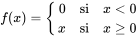

In [18]:
from tensorflow.keras import layers
#le on définie le nombre de classes ici nous disposons de 2 true et fake
num_classes = 2

#on va définir notre réseau de neuron (ici avec 4 couches )
model = tf.keras.Sequential([
    #on normalise dans un premier temps notre jeux de données
    layers.experimental.preprocessing.Rescaling(1./255),
    #on définie nos couches de convolution (128 neurons de départ  avec une fonction d'activation relu (Unité de rectification linéaire) ) et de pooling (avec un max pooling) 
    layers.Conv2D(128,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16,4, activation='relu'),
    layers.MaxPooling2D(),
    #transformer la matrice précédente ne vecteur qu'on va passer a un réseau dense
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    #on retourn ensuite la probabilté (softmax) entre nos deux classes
    layers.Dense(num_classes, activation='softmax')
])

#optimizer=adam et apparement le plus utilisé 
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'],)

logdir="logs"

tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=1, write_images=logdir,
                                                   embeddings_data=train_data)

#on va lancer l'entrainement (pour ma part ca a prit relativement assez de temps car je ne suis pas en GPU)
model.fit( 
  train_data,
  validation_data=val_data,
  epochs=15,
  callbacks=[tensorboard_callback]
)

Epoch 1/15
5/5 [==============================] - 5s 954ms/step - loss: 0.7567 - accuracy: 0.5046 - val_loss: 0.2170 - val_accuracy: 1.0000
Epoch 2/15
5/5 [==============================] - 4s 894ms/step - loss: 0.9161 - accuracy: 0.9056 - val_loss: 0.0221 - val_accuracy: 1.0000
Epoch 3/15
5/5 [==============================] - 4s 870ms/step - loss: 0.7240 - accuracy: 0.8037 - val_loss: 0.5598 - val_accuracy: 1.0000
Epoch 4/15
5/5 [==============================] - 5s 905ms/step - loss: 0.6545 - accuracy: 0.7574 - val_loss: 0.6526 - val_accuracy: 1.0000
Epoch 5/15
5/5 [==============================] - 5s 900ms/step - loss: 0.6695 - accuracy: 0.7435 - val_loss: 0.6004 - val_accuracy: 1.0000
Epoch 6/15
5/5 [==============================] - 5s 912ms/step - loss: 0.6165 - accuracy: 0.7435 - val_loss: 0.2204 - val_accuracy: 1.0000
Epoch 7/15
5/5 [==============================] - 4s 892ms/step - loss: 0.5302 - accuracy: 0.8870 - val_loss: 0.1715 - val_accuracy: 1.0000
Epoch 8/15
5/5 [====

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 197, 197, 128)     6272      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 98, 98, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 95, 95, 64)        131136    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 47, 47, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 44, 44, 32)        32800     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 22, 22, 32)       

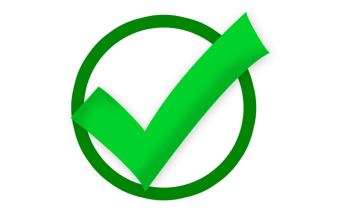

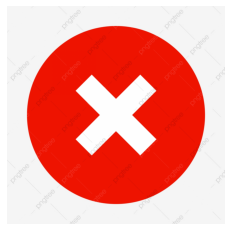

In [20]:
url_valide = r'http://7agestion.fr/wp-content/uploads/2017/03/ok-2282499_640.png'
resp = requests.get(url_valide, stream=True).raw
image_array_valide = np.asarray(bytearray(resp.read()), dtype="uint8")

image_valide = cv2.imdecode(image_array_valide, cv2.IMREAD_COLOR)
plt.axis('off')
plt.imshow(cv2.cvtColor(image_valide, cv2.COLOR_BGR2RGB)) #opencv if BGR color, matplotlib usr RGB so we need to switch otherwise the pikachu will be blue ... O:)
plt.show()

url_fake = r'https://png.pngtree.com/png-clipart/20190924/original/pngtree-false-free-png-png-image_4863857.jpg'
resp = requests.get(url_fake, stream=True).raw
image_array_fake = np.asarray(bytearray(resp.read()), dtype="uint8")

image_fake = cv2.imdecode(image_array_fake, cv2.IMREAD_COLOR)
plt.axis('off')
plt.imshow(cv2.cvtColor(image_fake, cv2.COLOR_BGR2RGB))
plt.show()

Saving 1616875589500.jpeg to 1616875589500.jpeg


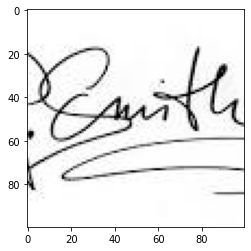

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[0]
[[0.79416054 0.20583953]]


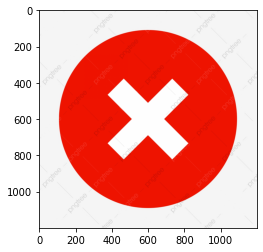

c'est une fausse  !


In [22]:
from google.colab import files
file_to_predict = files.upload()
for file_ in file_to_predict:
    image_to_predict = cv2.imread(file_,cv2.IMREAD_COLOR)
    plt.imshow(cv2.cvtColor(image_to_predict, cv2.COLOR_BGR2RGB))
    plt.show()
    img_to_predict = np.expand_dims(cv2.resize(image_to_predict,(200,200)), axis=0) 
    res = model.predict_classes(img_to_predict)
    print(model.predict_classes(img_to_predict))
    print(model.predict(img_to_predict))
    if res == 1:
        plt.imshow(cv2.cvtColor(image_valide, cv2.COLOR_BGR2RGB))
        plt.show()
        print("ce est une vrai !")
    elif res == 0 :
        plt.imshow(cv2.cvtColor(image_fake, cv2.COLOR_BGR2RGB))
        plt.show()
        print("c'est une fausse  !")